In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, confusion_matrix, average_precision_score
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
# import shap
# import xgboost as xgb

%matplotlib inline  
plt.rcParams['figure.figsize'] = (10.0, 8.0)
pd.options.display.max_columns = 50

### Pre-processing

In [2]:
# Copied and modified from sklearn documentation
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [5]:
### Currently the #1 most upvoted data set on Kaggle

In [3]:
df = pd.read_csv('creditcard.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

All variables are numeric and there doesn't seem to be any nulls. Let's check if that's true.

In [8]:
df.isnull().sum().sum()

0

Check class imbalance in target.

In [67]:
print('Fraud: ' + str(round(df['Class'].value_counts()[1] / len(df) * 100, 2)) + '%\nNot Fraud: ' + 
      str(round(df['Class'].value_counts()[0] / len(df) * 100, 2)) + '%')

Fraud: 0.17%
Not Fraud: 99.83%


Check distribution of Time & Amount.

Text(0.5,1,'Transaction Amount')

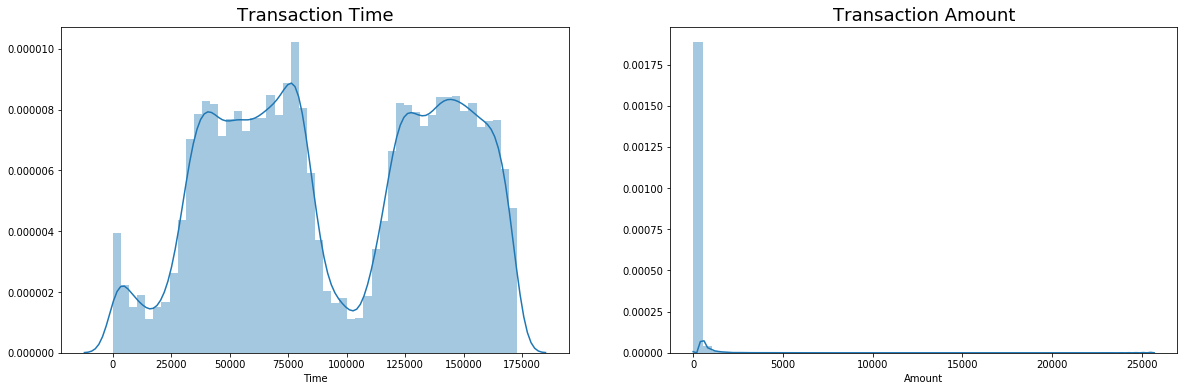

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
sns.distplot(df['Time'], ax=axes[0])
axes[0].set_title('Transaction Time', fontsize=18)
sns.distplot(df['Amount'], ax=axes[1])
axes[1].set_title('Transaction Amount', fontsize=18)

Amount has a very long tail. Try log transformation.

Text(0.5,1,'Log Transaction Amount')

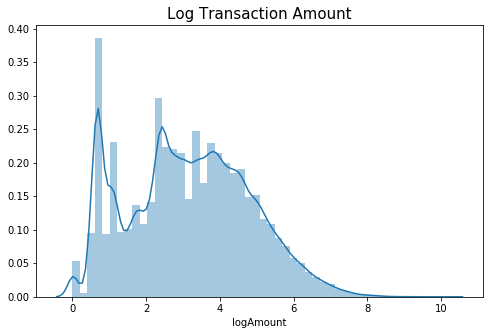

In [4]:
df['logAmount'] = (df['Amount']+1).apply(np.log)
sns.distplot(df['logAmount'])
plt.title('Log Transaction Amount', fontsize=15)

In [5]:
df.drop('Amount', axis=1, inplace=True)

### Detour: Isolation Forest

Isolation Forest is a fairly new unsupervised anomaly detection algorithm. This [blog post](https://blog.easysol.net/using-isolation-forests-anamoly-detection/) explains the basic intuition behind it and contains a video that visually illustrates how the algorithm works in a simplified 2D scenario.

In my own work, I had some success using this technique as a first step towards identifying fraudulent behavior. Let's see how the algorithm performs on the current data set.

In [ ]:
### No need to transform or standardize the IV since IsoForest is invariant to monotonic transformations.
iso = IsolationForest(n_estimators=1000, n_jobs=-1, verbose=10, max_features=1.0)
X = df.drop('Class', axis=1)
iso.fit(X)
df['anomalyscore'] = -iso.decision_function(X)

Text(0.5,1,'Anomaly Score Distribution')

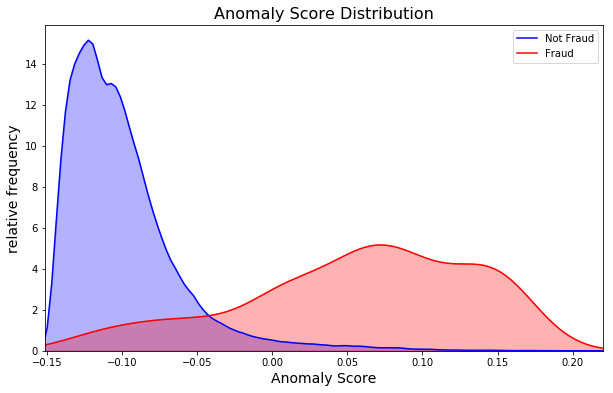

In [50]:
fig, ax = plt.subplots(1, figsize=(10, 6))
ax = sns.distplot(df[df['Class'] == 0]['anomalyscore'], hist=None, label='Not Fraud', color='blue')
ax = sns.distplot(df[df['Class'] == 1]['anomalyscore'], hist=None, label='Fraud', color='red')

# Get the two lines from the axes to generate shading
l1 = ax.lines[0]
l2 = ax.lines[1]

# Get the xy data from the lines so that we can shade
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
x2 = l2.get_xydata()[:,0]
y2 = l2.get_xydata()[:,1]
ax.fill_between(x1,y1, color='blue', alpha=0.3)
ax.fill_between(x2,y2, color='red', alpha=0.3)

ax.set_xlim(min(df['anomalyscore']), max(df['anomalyscore']))

ax.set_ylabel('relative frequency', fontsize=14)
ax.set_xlabel('Anomaly Score', fontsize=14)
ax.set_title('Anomaly Score Distribution', fontsize=16)

Unfortunately, the algorithm fails to achieve a clear separtaion between fraud & non-fraud data. Let's go back to data pre-processing.

### Pre-processing: continued

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Class', axis=1), df['Class'], test_size=0.2, random_state=42)

# Scale Time & logAmount
sc = StandardScaler()
X_train[['Time', 'logAmount']] = sc.fit_transform(X_train[['Time', 'logAmount']])
X_test[['Time', 'logAmount']] = sc.transform(X_test[['Time', 'logAmount']])

# Save an untransformed copy of the training set
df_train_orig = pd.concat([X_train, y_train], axis=1)

Because the target classes are highly imbalanced, accuracy is not an appropriate metric (see [Accuracy Paradox](https://en.wikipedia.org/wiki/Accuracy_paradox)). Since the goal is to detect fradulent transactions, I will use **PR AUC** as the scoring metric, with the goal of achieving high recall without sacrificing too much precision. I will also try out 2 re-balancing techniques: **simple under-sampling** and an oversampling technique called **SMOTE (Synthetic Minority Over-Sampling Technique)**.

Check correlation.

Text(0.5,1,'Correlation Matrix')

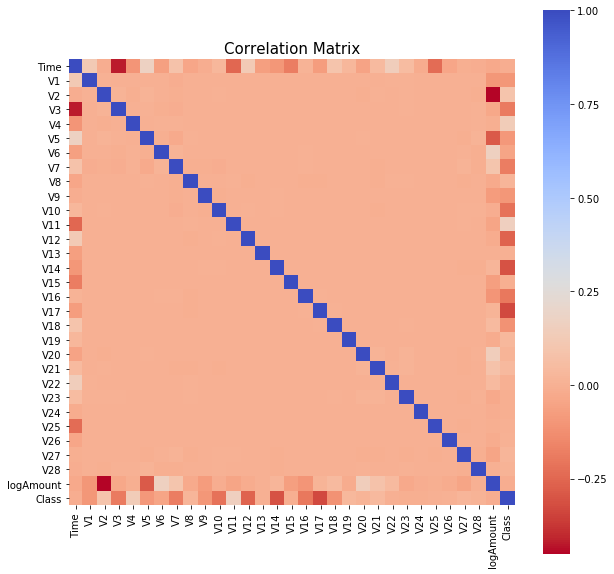

In [177]:
f, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(df_train.corr(), cmap='coolwarm_r', square=True)
plt.title('Correlation Matrix', fontsize=15)

Since nearly all the features are PCs, it makes sense that they're uncorrelated. Let's look at the correlation between features and the target.

Text(0.5,1,'Features vs Target Correlation')

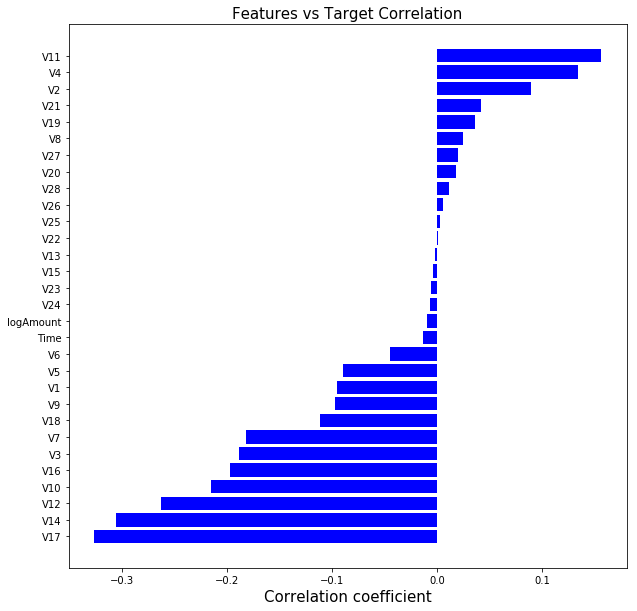

In [107]:
df_corr = df_train.corr().drop('Class').sort_values('Class')
fig, ax = plt.subplots(figsize=(10,10))
bars = ax.barh(np.arange(len(df_corr)), df_corr['Class'], color='b')
ax.set_yticks(np.arange(len(df_corr)))
ax.set_yticklabels(df_corr.index, rotation='horizontal')
ax.set_xlabel('Correlation coefficient', fontsize=15)
ax.set_title('Features vs Target Correlation', fontsize=15)

Since the target is binary, correlation matrix here is not as meaningful as in the case of regression. Still, it might be worthwile to visually inspect some of these features wrt the target.

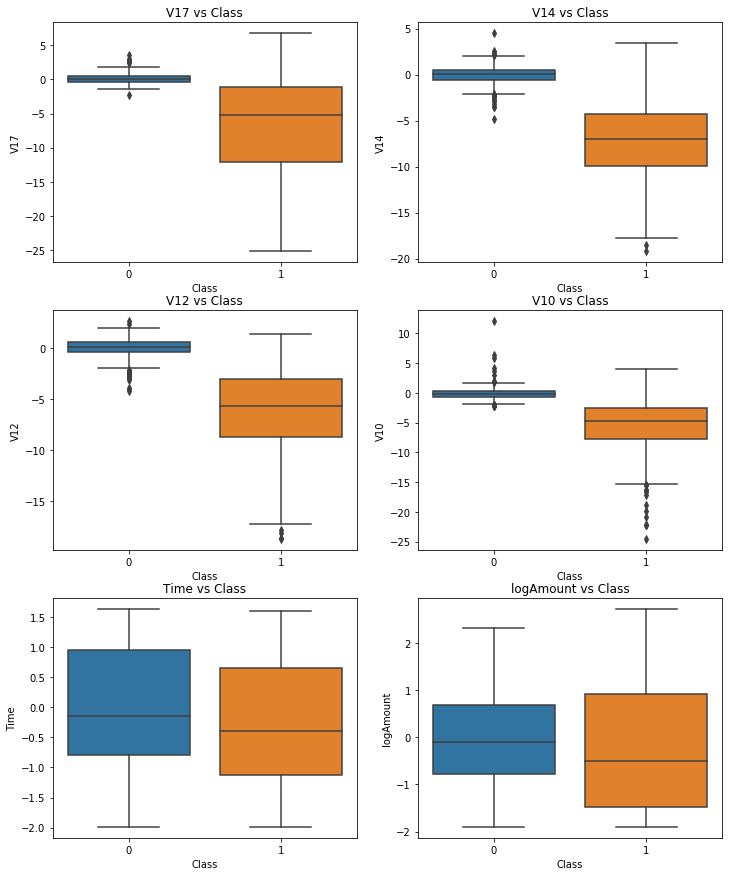

In [108]:
# Check top 4 PCs and Time & Amount
feature_list = ['V17', 'V14', 'V12', 'V10', 'Time', 'logAmount']
figure, axes = plt.subplots(3, 2, figsize=(12, 15))
for i in range(0, 6):
    feature = feature_list[i]
    sns.boxplot(x='Class', y=feature, data=df_train_us, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(feature + ' vs Class')

Despite some overlaps, there is good separation between the two classes from all 4 PC features. Time & Amount do not seem to matter that much in terms of identifying fraud.

For model building, I will use Logistic Regression for simplicity and compare the results using different sampling techniques (average precision is used as the scorer to approximate AUC for the Precision-Recall Curve).

### Logistic Regression

In [122]:
params_logit = {'C': [0.01,0.1,1,10,100]}
logit = LogisticRegression(solver='liblinear')
# Disable parallel processing to avoid temp file issue with the latest Python lib: https://github.com/joblib/joblib/issues/806
grid_logit = GridSearchCV(estimator=logit, param_grid=params_logit, scoring='average_precision', n_jobs=None, cv=5)
grid_logit.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.01, 0.1, 1, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='average_precision',
       verbose=0)

In [120]:
print('Training set score: ' + str(round(grid_logit.best_score_, 4)) + 
      '\nTest set score: ' + str(round(average_precision_score(y_test, grid_logit.predict_proba(X_test)[:,1]), 4)))

Training set score: 0.7627
Test set score: 0.7615


The score is not very high, probably due to the class imbalance. Let's look at the Precision Recall curve.

Text(0.5,1,'Precision Recall Curve')

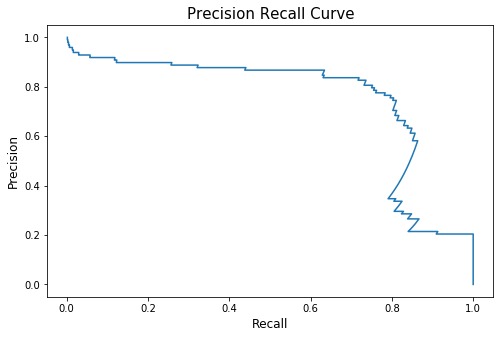

In [141]:
y_pred_prob = grid_logit.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(precision, recall)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision Recall Curve', fontsize=15)

The curve shows a steep drop in precision towards higher recall values. Let's take a look at the confusion matrix with a classification threshold of 0.005. 

In [143]:
def getPR(model, X_test, y_test, threshold=.5):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    y_pred = [1 if y > threshold else 0 for y in y_pred_prob]
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes=[0, 1], title='Confusion Matrix')
    precision = round(cm[1, 1] / sum(cm[:, 1]), 4)
    recall = round(cm[1, 1] / sum(cm[1, :]), 4)
    print('Precision: ' + str(precision) + '\nRecall: ' + str(recall))

Precision: 0.1789
Recall: 0.898


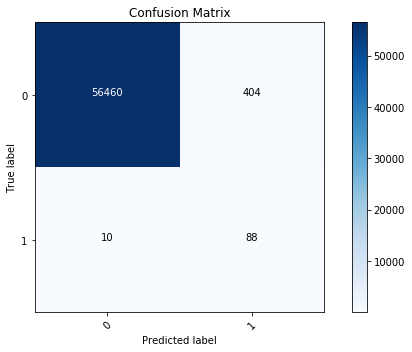

In [144]:
getPR(grid_logit, X_test, y_test, threshold=.005)

### Downsampling

Let's try a simple down-sampling of the training set and see if it improves the performance.

In [152]:
# Separate Class 0 and 1
df_train = df_train_orig.copy()
df_0 = df_train[df_train['Class'] == 0].copy()
df_1 = df_train[df_train['Class'] == 1].copy()
 
df_0 = df_0.sample(n=len(df_1), replace=False, random_state=42)
 
# Combine minority class with downsampled majority class
df_train_us = pd.concat([df_0, df_1])
 
# Display new class counts
X_train_us = df_train_us.drop('Class', axis=1)
y_train_us = df_train_us['Class']
df_train_us['Class'].value_counts()

1    394
0    394
Name: Class, dtype: int64

Text(0.5,0.98,'TSNE Plot')

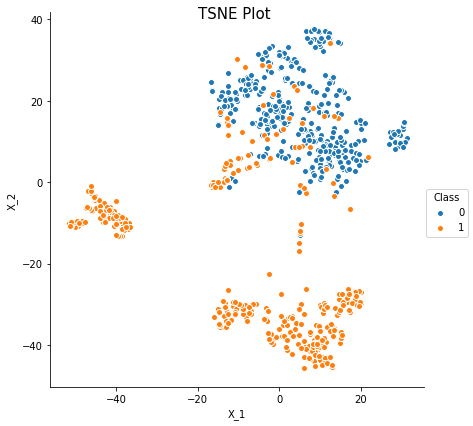

In [154]:
tsne = TSNE(n_components=2, random_state=42)
X_train_2d = tsne.fit_transform(X_train_us)
df_tsne = pd.DataFrame({'X_1': X_train_2d[:, 0], 'X_2': X_train_2d[:, 1], 'Class': y_train_us})

g = sns.pairplot(x_vars='X_1', y_vars='X_2', data=df_tsne, hue='Class', size=6)
g.fig.suptitle('TSNE Plot', fontsize=15)

TSNE plot shows good separation for the balanced training set.

In [155]:
grid_logit_us = GridSearchCV(estimator=logit, param_grid=params_logit, scoring='average_precision', n_jobs=None, cv=5)
grid_logit_us.fit(X_train_us, y_train_us)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.01, 0.1, 1, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='average_precision',
       verbose=0)

In [156]:
print('Training set score: ' + str(round(grid_logit_us.best_score_, 4)) + 
      '\nTest set score: ' + str(round(average_precision_score(y_test, grid_logit_us.predict_proba(X_test)[:,1]), 4)))

Training set score: 0.9817
Test set score: 0.7247


As expected, the cross-validated training set score improved dramatically. However, it fails to get out-perform the original model on the test set. This is probably because so much information was thrown away to balance the training set. A more sophisticated sampling technique might be able to address this problem.

### SMOTE oversampling

SMOTE oversampling is a popular sampling technique that uses KNN to create synthetic data points to balance the data. I will create a new training set using SMOTE and compare the performance against the previous results.

In [157]:
smote = SMOTE(ratio='minority')
X_train_sm, y_train_sm = smote.fit_sample(df_train_orig.drop('Class', axis=1), df_train_orig['Class'])

In [158]:
grid_logit_sm = GridSearchCV(estimator=logit, param_grid=params_logit, scoring='average_precision', n_jobs=None, cv=5)
grid_logit_sm.fit(X_train_sm, y_train_sm)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.01, 0.1, 1, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='average_precision',
       verbose=0)

In [159]:
print('Training set score: ' + str(round(grid_logit_sm.best_score_, 4)) + 
      '\nTest set score: ' + str(round(average_precision_score(y_test, grid_logit_sm.predict_proba(X_test)[:,1]), 4)))

Training set score: 0.9912
Test set score: 0.7296


Unfortunately, SMOTE also fails to improve on the original training set. Finally, let's plot out the PR curves.

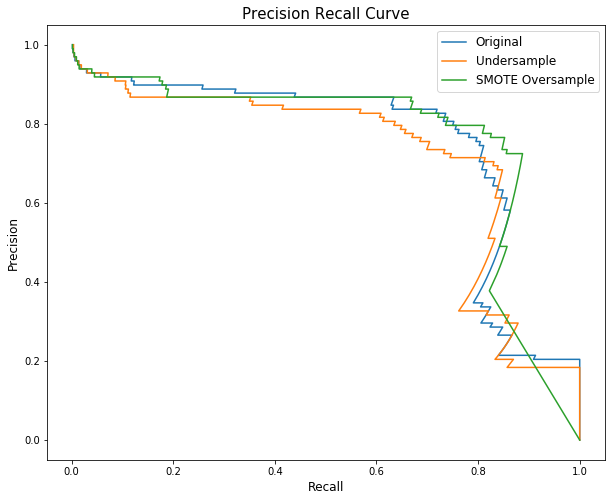

In [174]:
for model in [grid_logit, grid_logit_us, grid_logit_sm]:
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
    plt.plot(precision, recall)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision Recall Curve', fontsize=15)
plt.legend(['Original', 'Undersample', 'SMOTE Oversample'], fontsize=12)

It seems that SMOTE does outperform the original in the .6 - .9 recall range, but performs worse towards the extremes. In any case, there does not seem to be a clear benefit in balancing the training set in improving the test set score.

### Next steps

Try out other sampling techniques such as Tomek undersampling and a combination of Tomek & SMOTE. Also look at tree-based models like RandomForest and XGBoost.